In [3]:
import threading
from queue import Queue
import time

In [4]:
import gym

In [5]:
env=gym.make('MsPacman-v0')

In [6]:
obs=env.reset()

In [7]:
obs.shape

(210, 160, 3)

In [8]:
img=env.render(mode='rgb_array')

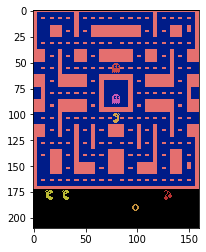

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [10]:
img.shape

(210, 160, 3)

In [11]:
env.action_space

Discrete(9)

In [12]:
def plot_enviroment(env,figsize=(5,4)):
    plt.close()
    plt.figure(figsize=figsize)
    img=env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [13]:
env.action_space

Discrete(9)

In [14]:
env.reset()
for step in range(110):
    env.step(3)
for step in range(40):
    env.step(8)

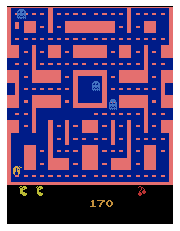

In [15]:
plot_enviroment(env)

In [16]:
obs,reward,done,info=env.step(3)

In [17]:
obs.shape

(210, 160, 3)

In [18]:
reward

10.0

In [19]:
done

False

In [20]:
info

{'ale.lives': 3}

In [21]:
env.close()

In [48]:
env=gym.make('CartPole-v0')

In [49]:
obs=env.reset()

In [24]:
obs.shape

(4,)

In [25]:
obs,reward,done,info=env.step(0)

In [26]:
obs.shape

(4,)

In [27]:
obs

array([ 0.00289301, -0.21844276,  0.03194412,  0.29267587])

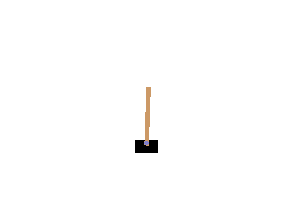

In [28]:
plot_enviroment(env)

In [29]:
env.close()

In [30]:
from PIL import Image,ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering=True
except Exception:
    openai_cart_pole_rendering=False
    
def render_cart_pole(env,obs):
    if openai_cart_pole_rendering:
        return env.render(mode='rgb_array')
    else:
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)
def plot_cart_pole(env,obs):
    plt.close()
    img=render_cart_pole(env,obs)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

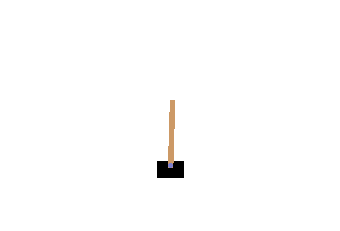

In [31]:
plot_cart_pole(env,obs)

In [32]:
env.close()

In [33]:
obs=env.reset()
while True:
    obs,reward,done,info=env.step(0)
    if done:
        break

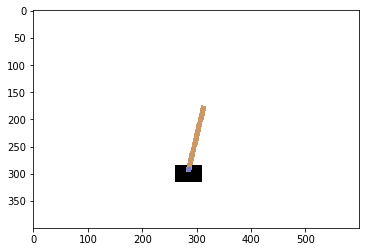

In [34]:
img=env.render('rgb_array')
plt.imshow(img)

In [35]:
img.shape

(400, 600, 3)

In [36]:
frames=[]
n_max_steps=10000
n_change_steps=10
obs=env.reset()
for step in range(n_max_steps):
    img=render_cart_pole(env,obs)
    frames.append(img)
    position,velocity,angle,angular_velocity=obs
    if angle<0:
        action=0
    else:
        action=1
    
    obs,reward,done,info=env.step(action)
    if done:
        break

In [37]:
env.close()

In [38]:
import tensorflow as tf
n_inputs=4
n_hidden=4
n_outputs=1
initializer=tf.variance_scaling_initializer()
X=tf.placeholder(tf.float32,shape=[None,n_inputs])
hidden=tf.layers.dense(X,n_hidden,activation=tf.nn.elu,kernel_initializer=initializer)
outputs=tf.layers.dense(hidden,n_outputs,activation=tf.nn.sigmoid,kernel_initializer=initializer)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

W0531 21:16:38.132002 140482778924864 deprecation.py:323] From <ipython-input-38-8244fdeddf55>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0531 21:16:38.529641 140482778924864 deprecation.py:323] From <ipython-input-38-8244fdeddf55>:10: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.random.categorical` instead.


In [39]:
from keras.layers import Dense
from keras.models import Sequential
model=Sequential()
model.add(Dense(n_hidden,activation='elu',input_shape=(None,n_inputs)))
model.add(Dense(n_outputs,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, None, 4)           20        
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [40]:
model(tf.convert_to_tensor(obs.reshape(1,n_inputs),dtype='float32'))

<tf.Tensor 'sequential_1/dense_2/Sigmoid:0' shape=(1, 1) dtype=float32>

In [41]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

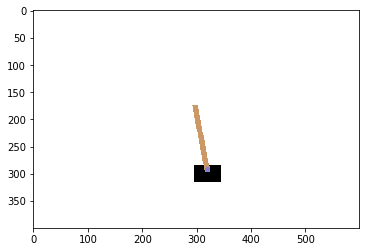

In [42]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [43]:
action_val[0][0]

1

In [44]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [46]:
reset_graph()
n_inputs = 4
n_hidden = 4
n_outputs = 1
learning_rate=0.01

initializer=tf.variance_scaling_initializer()

X=tf.placeholder(tf.float32,shape=[None,n_inputs])
y=tf.placeholder(tf.float32,shape=[None,n_outputs])

hidden=tf.layers.dense(X,n_hidden,activation=tf.nn.elu,kernel_initializer=initializer)
logits=tf.layers.dense(hidden,n_outputs)
outputs=tf.nn.sigmoid(logits)
p_left_and_right=tf.concat(axis=1,values=[outputs,1-outputs])
action=tf.multinomial(tf.log(p_left_and_right),num_samples=1)

cross_entropy=tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=logits)
optimizer=tf.train.AdamOptimizer(learning_rate)
training_op=optimizer.minimize(cross_entropy)

init=tf.global_variables_initializer()
saver=tf.train.Saver()

W0531 21:17:27.531992 140482778924864 deprecation.py:323] From /home/rahul/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [51]:
env.close()

In [52]:
n_enviroments=10
n_iterations=1000

envs=[gym.make('CartPole-v0') for _ in range(n_enviroments)]
observations=[env.reset() for env in envs]

with tf.Session() as Sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas=np.array([([1.] if obs[2]<0 else [0.]) for obs in observations])
        action_val,_=Sess.run([action,training_op],feed_dict={X:np.array(observations),y:target_probas})
        for env_index,env in enumerate(envs):
            obs,reward,done,info=env.step(action_val[env_index][0])
            observations[env_index]=obs if not done else env.reset()
            
    saver.save(sess,"./my_policy_net_basic.cpkt")
for env in envs:
    env.close()

RuntimeError: Attempted to use a closed Session.

In [57]:
import universe

ModuleNotFoundError: No module named 'universe'

In [55]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT

env = gym_tetris.make('Tetris-v0')
env = JoypadSpace(env, MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

UnregisteredEnv: No registered env with id: Tetris-v0

In [ ]:
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

In [ ]:
for i in range(100):
    obs=env.reset()
    env.render()
    action=env.action_space.sample()

In [ ]:
env.close()

In [ ]:
frames=[]
total_reward=[]
max_iter=2000
change_steps=10
env.reset()
for i in range(max_iter):
    img=env.render(mode='rgb_array')
    frames.append(img)
    if i%change_steps==0:
        action=env.action_space.sample()
    obs,reward, done,info=env.step(action)
    total_reward.append(reward)
    if done:
        break
env.close()

In [ ]:
frames=np.array(frames)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
model=Sequential()
model.add(Dense(15,activation='elu',input_shape=(210, 160, 3)))
model.add(Dense(10,activation='elu'))
model.add(Flatten())
model.add(Dense(1,activation='elu'))
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')

In [ ]:
np.array(total_reward).shape

In [ ]:
frames=np.array(frames).reshape(200,210,160,3)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler((0,0.99))

In [ ]:
total_reward=scaler.fit_transform(pd.DataFrame(total_reward)).flatten()

In [ ]:
history=model.fit(frames,total_reward,batch_size=1)